In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from scipy.stats import norm
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load data (replace 'file_path.csv' with your file)
file_path = "data.csv"  # Provide the file path to your dataset
data = pd.read_csv(file_path)

# Data Preprocessing
def preprocess_data(data):
    # Convert 'lastTradeDate' to datetime
    data['lastTradeDate'] = pd.to_datetime(data['lastTradeDate']).dt.tz_localize(None)

    # Calculate Time to Maturity (in years)
    today = datetime.today()
    data['Time_to_Maturity'] = 2.0

    # Calculate Underlying Price as midpoint of bid and ask
    data['Underlying_Price'] = (data['bid'] + data['ask']) / 2

    # Select relevant columns and rename for consistency
    processed_data = data[[
        'Underlying_Price', 'strike', 'Time_to_Maturity',
        'impliedVolatility', 'lastPrice'
    ]].rename(columns={
        'strike': 'Strike_Price',
        'impliedVolatility': 'Volatility',
        'lastPrice': 'Option_Price'
    })

    return processed_data

processed_data = preprocess_data(data)
print(processed_data.head())


   Underlying_Price  Strike_Price  Time_to_Maturity  Volatility  Option_Price
0           128.575         100.0               2.0    5.921878        127.30
1           103.575         125.0               2.0    4.421879         99.89
2            98.575         130.0               2.0    4.156255         99.15
3            93.575         135.0               2.0    3.890625         92.99
4            88.575         140.0               2.0    3.640626         84.82


In [2]:
# Black-Scholes Model
def black_scholes(S, K, T, r, sigma, option_type="call"):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == "call":
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == "put":
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)


In [3]:
# Add Black-Scholes Prices
risk_free_rate = 0.03  # Assume a constant risk-free rate
processed_data['BS_Price'] = processed_data.apply(
    lambda x: black_scholes(
        S=x['Underlying_Price'],
        K=x['Strike_Price'],
        T=x['Time_to_Maturity'],
        r=risk_free_rate,
        sigma=x['Volatility'],
        option_type="call"  # Assuming call options for simplicity
    ), axis=1
)
print(processed_data.head())


   Underlying_Price  Strike_Price  Time_to_Maturity  Volatility  Option_Price  \
0           128.575         100.0               2.0    5.921878        127.30   
1           103.575         125.0               2.0    4.421879         99.89   
2            98.575         130.0               2.0    4.156255         99.15   
3            93.575         135.0               2.0    3.890625         92.99   
4            88.575         140.0               2.0    3.640626         84.82   

     BS_Price  
0  128.571897  
1  103.379859  
2   98.213381  
3   92.927963  
4   87.492216  


In [4]:
# Features and Target
X = processed_data[['Underlying_Price', 'Strike_Price', 'Time_to_Maturity', 'Volatility']]
y = processed_data['Option_Price']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
print("Random Forest MSE:", mse_rf)

# Neural Network Model
nn_model = MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42)
nn_model.fit(X_train, y_train)
y_pred_nn = nn_model.predict(X_test)
mse_nn = mean_squared_error(y_test, y_pred_nn)
print("Neural Network MSE:", mse_nn)


Random Forest MSE: 2.3491127963637197
Neural Network MSE: 0.4268873352930322


Black-Scholes MSE: 101.71200929335204


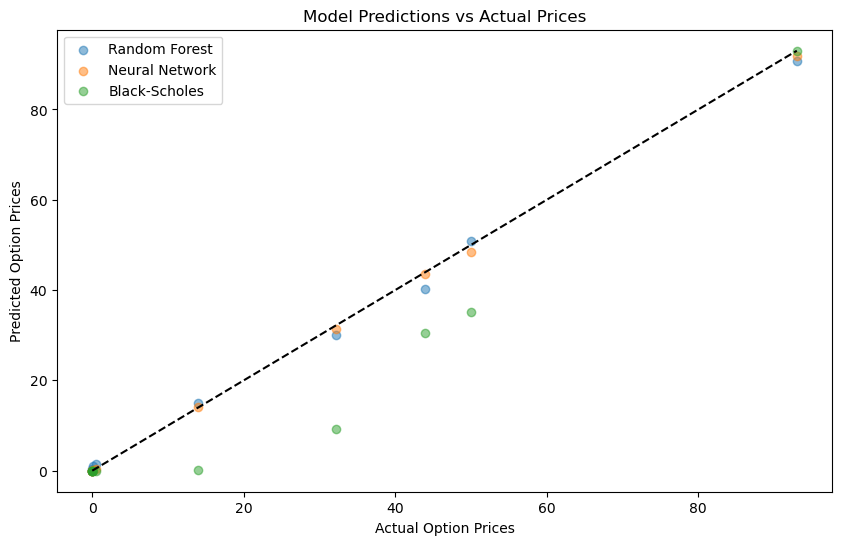

In [5]:
# Black-Scholes Predictions
bs_prices = [
    black_scholes(S, K, T, risk_free_rate, sigma)
    for S, K, T, sigma in zip(
        X_test['Underlying_Price'], X_test['Strike_Price'],
        X_test['Time_to_Maturity'], X_test['Volatility']
    )
]

# Calculate MSE for Black-Scholes
mse_bs = mean_squared_error(y_test, bs_prices)
print("Black-Scholes MSE:", mse_bs)

# Visualize Predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, label="Random Forest", alpha=0.5)
plt.scatter(y_test, y_pred_nn, label="Neural Network", alpha=0.5)
plt.scatter(y_test, bs_prices, label="Black-Scholes", alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="black", linestyle="--")
plt.xlabel("Actual Option Prices")
plt.ylabel("Predicted Option Prices")
plt.legend()
plt.title("Model Predictions vs Actual Prices")
plt.show()
